In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import colorlover as cl
colors = [[i / 255 for i in j] for j in cl.to_numeric(cl.scales['5']['qual']['Dark2'])]

### Functions

In [2]:
def dist(x1, y1, x2, y2):
    return np.sqrt(np.power(x1 - x2, 2) + np.power(y1 - y2, 2))

def ny_scatter2(ax, df, coord_col_name = "test_{}_rank"):
    # fig, ax = plt.subplots(figsize = (s, s))
    for ind, county in enumerate(df.county_name.unique()):
        county_df = df[df.county_name == county]
        ax.scatter(
            y = county_df[coord_col_name.format("lat")],
            x = county_df[coord_col_name.format("lng")],
            s = county_df.sqrt_mult * 2,
            marker = "s",
            label = county,
            alpha = 0.7,
            color = colors[ind % 5],
            edgecolor = "none")
    # ax.legend(loc = 9, bbox_to_anchor = (0.5,0))
    # return fig

def check_intersect_ver2(row):
    def rev_pair(l):
        return [l, l[::-1]]
    
    return (min(
        [(row["new_scaled_{}_rank_{}".format(i, j[0])] - row["sqrt_mult_{}".format(j[0])] / 2) <=
         (row["new_scaled_{}_rank_{}".format(i, j[1])] + row["sqrt_mult_{}".format(j[0])] / 2)
        for i in ["lng", "lat"] for j in rev_pair(["x", "y"])]))

def get_min_max(df, center_col_name = "prop_scaled_{}_rank", side_col_name = "sqrt_mult"):
    for si, i in enumerate(["min", "max"]):
        for j in ["lat", "lng"]:
            df[("{}_" + center_col_name).format(i, j)] = (
                df[center_col_name.format(j)] + (2 * si - 1) *
                (df[side_col_name] / 2))
    return df

def get_pairs(df, id_col_name, select_col_names):
    df["dummy"] = 1
    pairs = df[select_col_names + ["dummy"]].merge(right = df[select_col_names+ ["dummy"]], on = "dummy", how = "left")
    return pairs[~(pairs[id_col_name + "_x"] == pairs[id_col_name + "_y"])].drop(columns = ["dummy"]) 

def get_intersect(df, center_col_name = "new_scaled_{}_rank_{}"):
    col_pat = "{}_" + center_col_name
    return (
        (df[col_pat.format("min", "lat", "x")] <= df[col_pat.format("max", "lat", "y")]) &
        (df[col_pat.format("min", "lat", "y")] <= df[col_pat.format("max", "lat", "x")]) &
        (df[col_pat.format("min", "lng", "x")] <= df[col_pat.format("max", "lng", "y")]) &
        (df[col_pat.format("min", "lng", "y")] <= df[col_pat.format("max", "lng", "x")]))    

def compress(ny_map_county_shapes):
    # get square pairs
    select_cols = ["square_id"] + ["new_scaled_{}_rank".format(i) for i in ["lat", "lng"]]
    ny_map_county_square_pairs = get_pairs(ny_map_county_shapes, "square_id", select_cols)    
    
    # calculate each square's force on each other county
    # scaled by the distance between squares
    d = dist(*[ny_map_county_square_pairs["new_scaled_{}_rank_{}".format(j, i)] for i in ["x", "y"] for j in ["lat", "lng"]])
    min_d = d.min()
    max_d = d.max()
    a = - 0.001 / ((min_d - max_d) ** 2)
    d_factor = 1 / d # a * (min_d - d) * (max_d - d)
    
    for i in ["lat", "lng"]:
        ny_map_county_square_pairs["force_{}".format(i)] = (d_factor * 
            (ny_map_county_square_pairs["new_scaled_{}_rank_y".format(i)] - ny_map_county_square_pairs["new_scaled_{}_rank_x".format(i)]))
        
    # add all forces together
    sum_forces = ny_map_county_square_pairs.groupby(
        ["square_id_x"], as_index = False).agg(
        {"force_{}".format(i): "sum" for i in ["lat", "lng"]})
    
    # join sum of forces to squares data
    ny_map_county_shapes = ny_map_county_shapes.merge(
        right = sum_forces,
        left_on = ["square_id"],
        right_on = ["square_id_x"],
        how = "left")
    
    # calculate a proposed new center for each square 
    for i in ["lat", "lng"]:
        ny_map_county_shapes["prop_scaled_{}_rank".format(i)] = (ny_map_county_shapes["new_scaled_{}_rank".format(i)] +
            ny_map_county_shapes["force_{}".format(i)])
        
    # check intersection
    ny_map_county_shapes = get_min_max(ny_map_county_shapes)
    select_cols = (
        ["square_id", "sqrt_mult"] +
        ["{}prop_scaled_{}_rank".format(j, i) for i in ["lat", "lng"] for j in ["", "min_", "max_"]])
    ny_map_county_square_pairs = get_pairs(ny_map_county_shapes, "square_id", select_cols)
    ny_map_county_square_pairs["intersect"] = get_intersect(ny_map_county_square_pairs, center_col_name = "prop_scaled_{}_rank_{}")
    
    square_intersect = ny_map_county_square_pairs.groupby(["square_id_x"], as_index = False)["intersect"].sum()
    ny_map_county_shapes = ny_map_county_shapes.merge(right = square_intersect, on = "square_id_x", how = "left")
    
    # apply force if no intersect
    for i in ["lat", "lng"]:
        ny_map_county_shapes["new_scaled_{}_rank".format(i)] = ny_map_county_shapes.apply(
            lambda x: x["new_scaled_{}_rank".format(i)] if x["intersect"] else x["prop_scaled_{}_rank".format(i)], axis = 1)
    
    return [ny_map_county_shapes.drop(columns = ["force_{}".format(i) for i in ["lat", "lng"]] + ["square_id_x", "intersect"]), ny_map_county_square_pairs]

### Import data

In [3]:
county_shapes = pd.read_csv("./ny_county_shapes.csv").set_index("county_name")
ny_map_county_shapes = pd.read_csv("./ny_map_county_squares.csv")

### Untangle

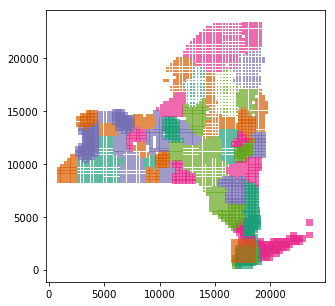

In [4]:
fig, ax = plt.subplots(figsize = (5, 5))
ny_scatter2(ax, ny_map_county_shapes)

In [5]:
for i in ["lat", "lng"]:
    ny_map_county_shapes["new_scaled_{}_rank".format(i)] = ny_map_county_shapes["test_{}_rank".format(i)]

In [6]:
ny_map_county_shapes["square_id"] = ny_map_county_shapes.index

In [7]:
# check to make sure squares dont intersect
ny_map_county_shapes_min_max = get_min_max(ny_map_county_shapes, center_col_name = "new_scaled_{}_rank")
select_cols = ["square_id", "sqrt_mult"] + ["{}new_scaled_{}_rank".format(j, i) for i in ["lat", "lng"] for j in ["", "min_", "max_"]]
ny_map_county_square_pairs = get_pairs(ny_map_county_shapes, "square_id", select_cols)

In [8]:
ny_map_county_square_pairs["intersect"] = get_intersect(ny_map_county_square_pairs)

In [9]:
ny_map_county_square_pairs.intersect.min(), ny_map_county_square_pairs.intersect.max()

(False, False)

### Intersect test

In [10]:
# need a test df with new_scaled_{}_rank_{} (lat, lng, x, y) and sqrt_mult_{} (x, y)
intersect_test = [
    [0, 0, 1, 1],
    [1, 1, 1, 1],
    [2, 2, 2, 1],
    [3, 3, 2, 1],
    [5, 5, 5, 1],
    [10, 10, 10, 1],
]
intersect_test_df = pd.DataFrame(
    intersect_test,
    columns = ["square_id"] + ["new_scaled_{}_rank".format(i) for i in ["lat", "lng"]] + ["sqrt_mult"])

intersect_test_df = get_min_max(intersect_test_df, center_col_name = "new_scaled_{}_rank")
intersect_test_pairs_df = get_pairs(intersect_test_df, "square_id", list(intersect_test_df.columns))

In [11]:
intersect_test_pairs_df

,square_id_x,new_scaled_lat_rank_x,new_scaled_lng_rank_x,sqrt_mult_x,min_new_scaled_lat_rank_x,min_new_scaled_lng_rank_x,max_new_scaled_lat_rank_x,max_new_scaled_lng_rank_x,square_id_y,new_scaled_lat_rank_y,new_scaled_lng_rank_y,sqrt_mult_y,min_new_scaled_lat_rank_y,min_new_scaled_lng_rank_y,max_new_scaled_lat_rank_y,max_new_scaled_lng_rank_y
1,0,0,1,1,-0.5,0.5,0.5,1.5,1,1,1,1,0.5,0.5,1.5,1.5
2,0,0,1,1,-0.5,0.5,0.5,1.5,2,2,2,1,1.5,1.5,2.5,2.5
3,0,0,1,1,-0.5,0.5,0.5,1.5,3,3,2,1,2.5,1.5,3.5,2.5
4,0,0,1,1,-0.5,0.5,0.5,1.5,5,5,5,1,4.5,4.5,5.5,5.5
5,0,0,1,1,-0.5,0.5,0.5,1.5,10,10,10,1,9.5,9.5,10.5,10.5
6,1,1,1,1,0.5,0.5,1.5,1.5,0,0,1,1,-0.5,0.5,0.5,1.5
8,1,1,1,1,0.5,0.5,1.5,1.5,2,2,2,1,1.5,1.5,2.5,2.5
9,1,1,1,1,0.5,0.5,1.5,1.5,3,3,2,1,2.5,1.5,3.5,2.5
10,1,1,1,1,0.5,0.5,1.5,1.5,5,5,5,1,4.5,4.5,5.5,5.5
11,1,1,1,1,0.5,0.5,1.5,1.5,10,10,10,1,9.5,9.5,10.5,10.5


In [12]:
get_intersect(intersect_test_pairs_df)

1      True
2     False
3     False
4     False
5     False
6      True
8      True
9     False
10    False
11    False
12    False
13     True
15     True
16    False
17    False
18    False
19    False
20     True
22    False
23    False
24    False
25    False
26    False
27    False
29    False
30    False
31    False
32    False
33    False
34    False
dtype: bool

In [13]:
compress(intersect_test_df)[0]

,square_id,new_scaled_lat_rank,new_scaled_lng_rank,sqrt_mult,min_new_scaled_lat_rank,min_new_scaled_lng_rank,max_new_scaled_lat_rank,max_new_scaled_lng_rank,dummy,prop_scaled_lat_rank,prop_scaled_lng_rank,min_prop_scaled_lat_rank,min_prop_scaled_lng_rank,max_prop_scaled_lat_rank,max_prop_scaled_lng_rank
0,0,4.367273,3.057101,1,-0.5,0.5,0.5,1.5,1,4.367273,3.057101,3.867273,2.557101,4.867273,3.557101
1,1,1.000000,1.000000,1,0.5,0.5,1.5,1.5,1,3.015748,3.568534,2.515748,3.068534,3.515748,4.068534
2,2,2.000000,2.000000,1,1.5,1.5,2.5,2.5,1,2.812680,2.259893,2.312680,1.759893,3.312680,2.759893
3,3,1.370094,2.821186,1,2.5,1.5,3.5,2.5,1,1.370094,2.821186,0.870094,2.321186,1.870094,3.321186
4,5,5.000000,5.000000,1,4.5,4.5,5.5,5.5,1,2.957324,2.836148,2.457324,2.336148,3.457324,3.336148
5,10,6.476881,6.457138,1,9.5,9.5,10.5,10.5,1,6.476881,6.457138,5.976881,5.957138,6.976881,6.957138


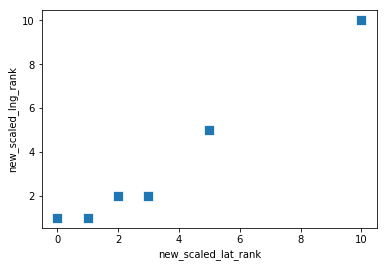

In [14]:
sns.scatterplot(
    data = intersect_test_df,
    x = "new_scaled_lat_rank",
    y = "new_scaled_lng_rank",
    marker = "s",
    s = 100)

In [15]:
def apply_compress(df, ntimes):
    if ntimes == 0:
        return df
    else:
        return apply_compress(compress(df)[0], ntimes - 1)

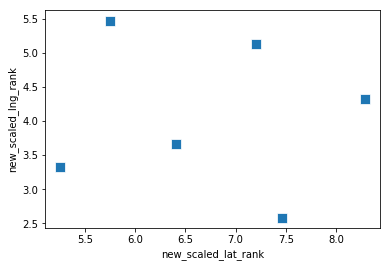

In [16]:
sns.scatterplot(
    data = apply_compress(intersect_test_df, 11),
    x = "new_scaled_lat_rank",
    y = "new_scaled_lng_rank",
    marker = "s",
    s = 100)

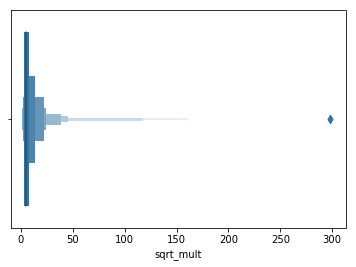

In [17]:
sns.boxenplot(ny_map_county_shapes.sqrt_mult)

In [18]:
niter = 20

In [19]:
prev = ny_map_county_shapes
test_dfs = []

for i in tqdm(range(niter)):
    test_dfs.append(compress(prev)[0])
    # print(compress(prev)[1].intersect.min(), compress(prev)[1].intersect.max())
    prev = test_dfs[-1]

100%|██████████| 20/20 [02:07<00:00,  6.36s/it]


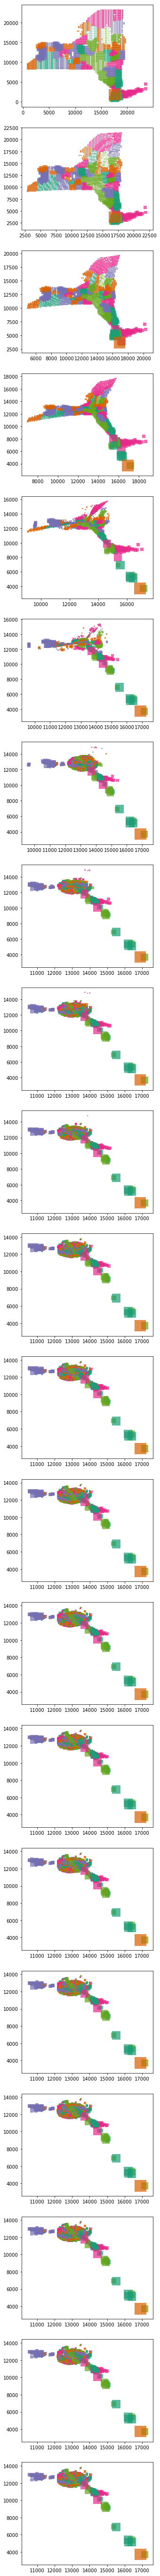

In [20]:
fig, ax = plt.subplots(figsize = (5, niter * 5), nrows = niter + 1)#, sharey = True, sharex = True)
ny_scatter2(ax[0], ny_map_county_shapes)
for i in range(niter):
    ny_scatter2(ax[i + 1], test_dfs[i], coord_col_name = "new_scaled_{}_rank")

In [21]:
test_dfs[-1].drop(columns = ["state", "nyc", 'min_lng_rank', 'min_lat_rank', 'max_lng_rank', 'max_lat_rank',
       'num_squares', 'county', 'ttl', 'pre_mult', 'mult']).head()

,county_name,lat,lng,lng_rank,lat_rank,sqrt_mult,mid_lng_rank,mid_lat_rank,scaled_lng_rank,scaled_lat_rank,...,min_new_scaled_lng_rank,max_new_scaled_lat_rank,max_new_scaled_lng_rank,dummy,prop_scaled_lat_rank,prop_scaled_lng_rank,min_prop_scaled_lat_rank,min_prop_scaled_lng_rank,max_prop_scaled_lat_rank,max_prop_scaled_lng_rank
0,Montgomery,42.920886,-74.476076,54.0,43.0,5.224579,54.5,42.5,51.387710,45.612290,...,16097.304790,12822.916631,16102.529369,1,12297.130560,12170.383323,12294.518270,12167.771034,12299.742850,12172.995613
1,Chautauqua,42.162278,-79.666456,3.0,30.0,6.386439,5.5,32.0,-12.966097,17.227123,...,891.246618,8947.591597,897.633057,1,12690.126125,13258.873766,12686.932905,13255.680547,12693.319344,13262.066986
2,Rensselaer,42.862532,-73.661899,62.0,42.0,9.693078,63.0,39.5,52.306922,66.232695,...,18480.243441,12527.004268,18489.936519,1,12290.144912,13760.562106,12285.298373,13755.715567,12294.991451,13765.408645
3,St Lawrence,44.379747,-75.392025,45.0,68.0,3.236011,47.0,70.5,38.527978,59.909972,...,13414.979561,20275.587661,13418.215572,1,11599.404670,12855.698631,11597.786664,12854.080626,11601.022675,12857.316637
4,Delaware,41.987215,-74.984937,49.0,27.0,3.238251,49.5,30.0,47.380874,17.285246,...,14607.564891,8051.577665,14610.803142,1,11685.106673,13144.921469,11683.487547,13143.302344,11686.725799,13146.540595


In [22]:
test = get_min_max(test_dfs[-1])

In [23]:
test[test.county == "Bronx"].drop(columns = ["state", "nyc", 'min_lng_rank', 'min_lat_rank', 'max_lng_rank', 'max_lat_rank',
       'num_squares', 'county', 'ttl', 'pre_mult', 'mult', 'mid_lng_rank', 'mid_lat_rank', 'scaled_lng_rank', 'scaled_lat_rank',
       'test_lat_rank', 'test_lng_rank'])

,county_name,lat,lng,lng_rank,lat_rank,sqrt_mult,new_scaled_lat_rank,new_scaled_lng_rank,square_id,min_new_scaled_lat_rank,min_new_scaled_lng_rank,max_new_scaled_lat_rank,max_new_scaled_lng_rank,dummy,prop_scaled_lat_rank,prop_scaled_lng_rank,min_prop_scaled_lat_rank,min_prop_scaled_lng_rank,max_prop_scaled_lat_rank,max_prop_scaled_lng_rank
444,Bronx,40.878481,-73.865443,60.0,8.0,154.023147,11755.687253,13708.778257,444,2308.161327,17811.785182,2462.184474,17965.808329,1,12968.787172,12406.510079,12891.775599,12329.498505,13045.798746,12483.521652
1547,Bronx,40.820127,-73.865443,60.0,7.0,154.023147,10061.025403,14444.069264,1547,2010.014715,17811.785182,2164.037862,17965.808329,1,11955.747586,13301.169167,11878.736012,13224.157593,12032.759159,13378.180741


In [24]:
test.to_csv("./untangled_county_squares.csv", index = False)